<a href="https://colab.research.google.com/github/Oyekanmi/Machine-Learning-New/blob/master/Casting_Defect_Classifier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset is from kaggle : https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product


**About**

This dataset is of casting manufacturing product.
Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.
Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.
There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.
Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate. 

**Import Libraries**

In [1]:
#import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import TensorBoard
from PIL import Image
import os
import cv2
import glob

%matplotlib inline

**Check the GPU available**

In [2]:
#Check if there is a GPU available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


**Read Images from google drive**

In [3]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/Casting_images/archive.zip", "/content/casting_images")

In [4]:
#check the class labels
class_labels = os.listdir('/content/casting_images/casting_data/casting_data/train')
class_labels

['def_front', 'ok_front']

**Define the training and testing path**

In [5]:
train_path= "/content/casting_images/casting_data/casting_data/train"
test_path= "/content/casting_images/casting_data/casting_data/test"

**Rename folders**

In [6]:
os.rename(os.path.join(train_path,"def_front"), os.path.join(train_path,"defective"))
os.rename(os.path.join(train_path,"ok_front"), os.path.join(train_path,"good"))
os.rename(os.path.join(test_path,"def_front"), os.path.join(test_path,"defective"))
os.rename(os.path.join(test_path,"ok_front"), os.path.join(test_path,"good"))

In [7]:
#check the number of classes in the dataset
print(f"There are {len(class_labels)} classes in total")

There are 2 classes in total


In [8]:
#confirm the renamed class labels
class_labels = os.listdir(train_path)
class_labels

['good', 'defective']

**Visualize the number of images per class**

In [9]:
#Define a function that creates a list of all images in a directory
def get_imlist(path):
  """  Returns a list of filenames for
    all jpg images in a directory. """

  return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpeg')]

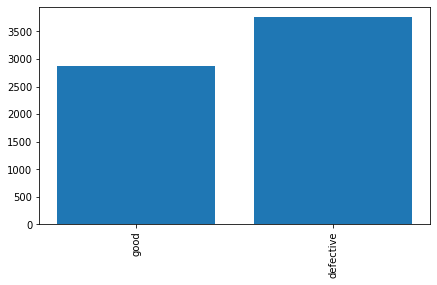

In [10]:
##Count the number of images per class 
image_counts_list= []
for label in class_labels :
  path = os.path.join(train_path,label)                    
  image_counts = len(get_imlist(path))
  image_counts_list.append(image_counts)


#Plot the number of images per class
plt.figure(figsize=(7,4))

plt.bar(x=class_labels , height=image_counts_list);
plt.xticks(x=class_labels, rotation='vertical');

**Create training and validation images**

In [11]:
image_size = (224, 224)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 6633 files belonging to 2 classes.
Using 5307 files for training.
Found 6633 files belonging to 2 classes.
Using 1326 files for validation.
Found 715 files belonging to 2 classes.


**Visualize some of the training images in the first batch**

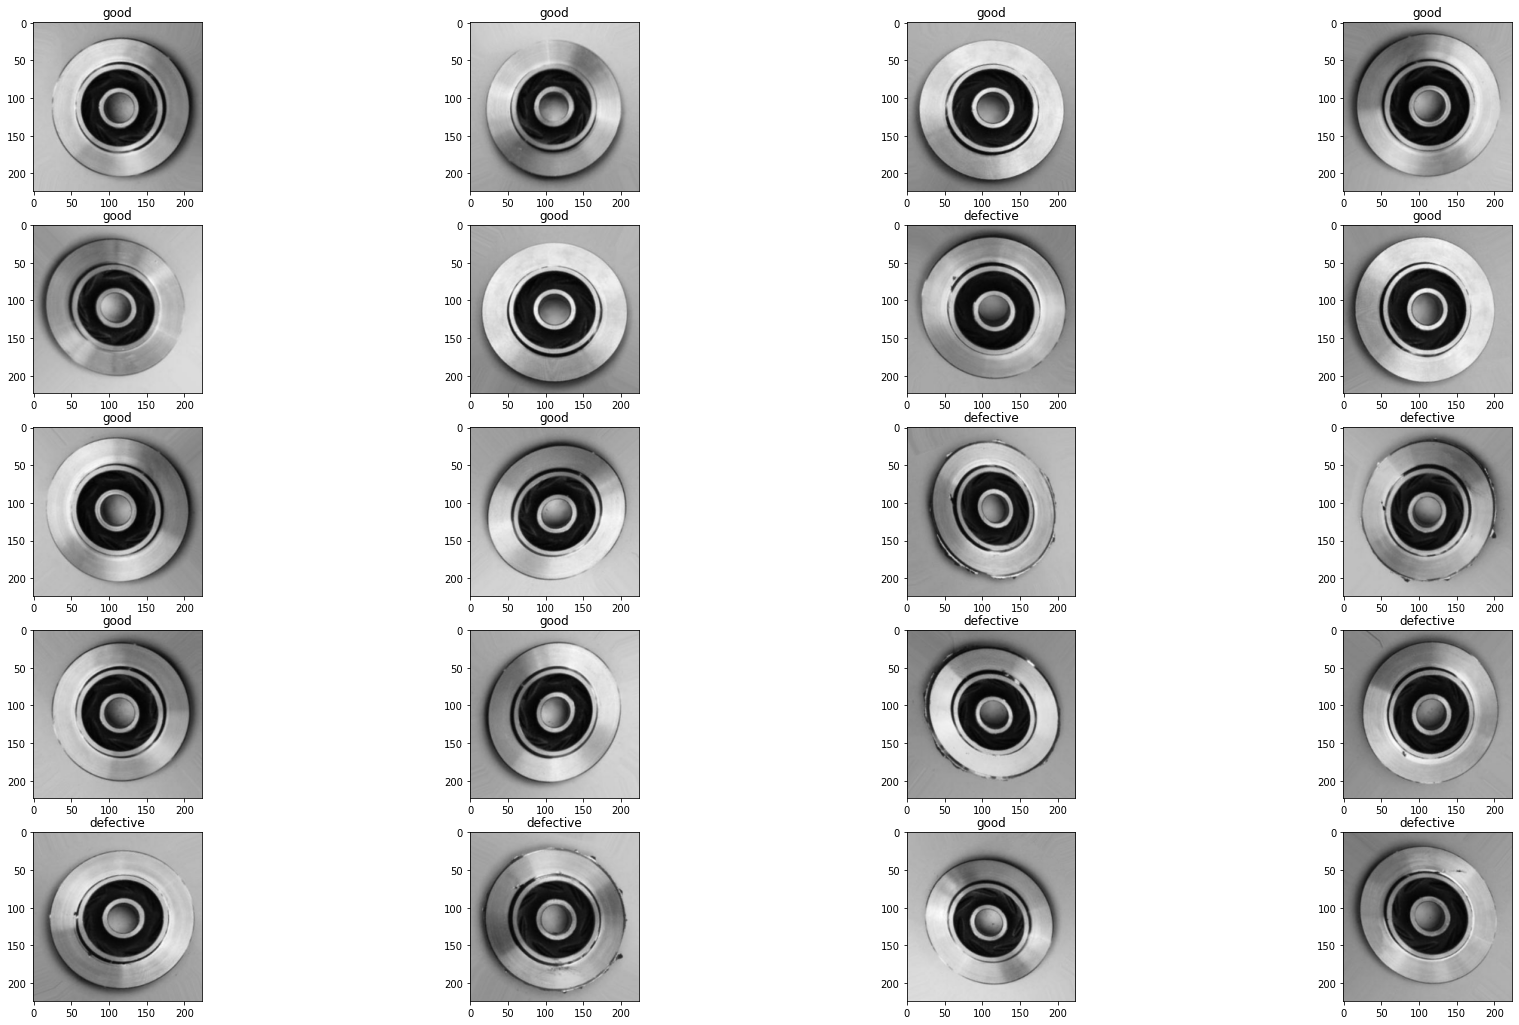

In [12]:
import matplotlib.pyplot as plt

#gat all the unique class names in the training images
class_names = train_ds.class_names


#display first 20 images in a random training batch 
plt.figure(figsize=(30, 18))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

**Configure dataset for optimized performance**

In [13]:
#Use autotune prefetch to optimize the efficiency between the input data fetching pipeline and model training pipeline
#It helps to overlap the preprocessing and model execution step of the training 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Define the augmentation process**

In [14]:
img_height, img_width=224,224

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(0.1),
        #tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        #layers.experimental.preprocessing.RandomCrop(0.2,0.2)
    ]
)

**Visualize samples of augmented images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


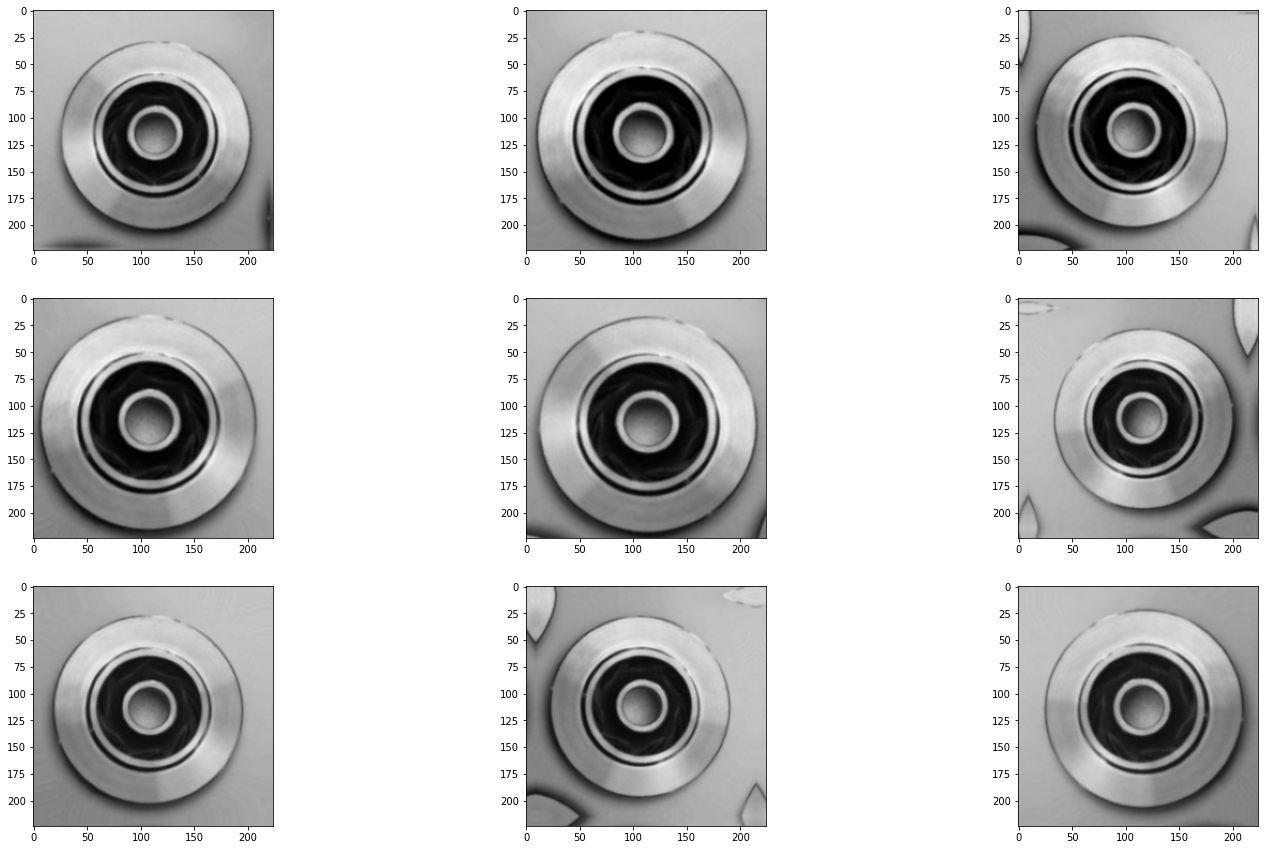

In [16]:
#take a batch of the training images , apply augmentation and visualize the first one
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(25, 15))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0));
    plt.imshow(augmented_image[0] / 255);

**Build Custom Model**

In [17]:
model = tf.keras.models.Sequential([
                                        data_augmentation,
                                        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                                        tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same'),
                                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')

    ])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy']) 

In [18]:
from tensorflow.keras.utils import plot_model

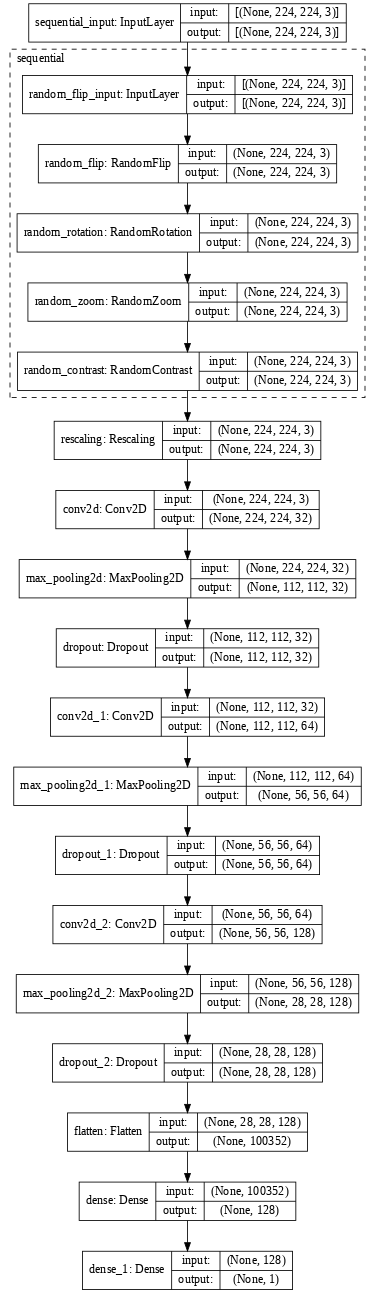

In [19]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

**Define learning rate scheduler**

In [20]:
import math
import tensorflow as tf

from keras.callbacks import LearningRateScheduler

In [21]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.25
   epochs_drop =15.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [22]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [23]:
epochs=50
model_history=model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset, callbacks=callbacks_list)

Epoch 1/50
83/83 [==============================] - 25s 100ms/step - loss: 0.8114 - accuracy: 0.5662 - val_loss: 0.6524 - val_accuracy: 0.5633
Epoch 2/50
83/83 [==============================] - 6s 70ms/step - loss: 0.6198 - accuracy: 0.6629 - val_loss: 0.5551 - val_accuracy: 0.6878
Epoch 3/50
83/83 [==============================] - 6s 69ms/step - loss: 0.5333 - accuracy: 0.7317 - val_loss: 0.5050 - val_accuracy: 0.7730
Epoch 4/50
83/83 [==============================] - 6s 69ms/step - loss: 0.4382 - accuracy: 0.7999 - val_loss: 0.6137 - val_accuracy: 0.6433
Epoch 5/50
83/83 [==============================] - 6s 69ms/step - loss: 0.3219 - accuracy: 0.8624 - val_loss: 0.3717 - val_accuracy: 0.8183
Epoch 6/50
83/83 [==============================] - 6s 69ms/step - loss: 0.2585 - accuracy: 0.8869 - val_loss: 0.3513 - val_accuracy: 0.8167
Epoch 7/50
83/83 [==============================] - 6s 70ms/step - loss: 0.2075 - accuracy: 0.9171 - val_loss: 0.1897 - val_accuracy: 0.9208
Epoch 8/50


**Plot Results**

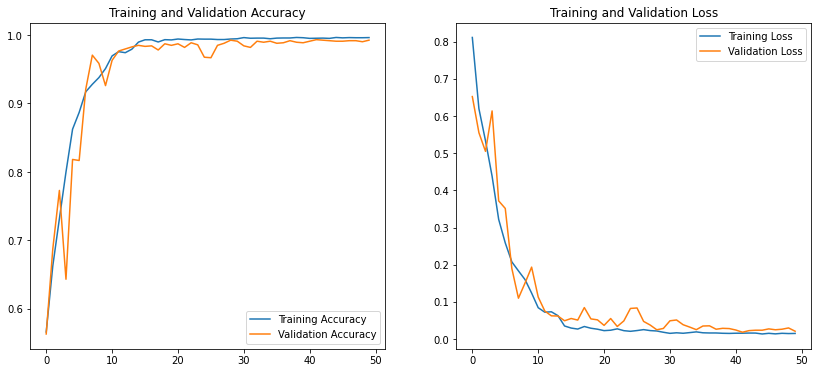

In [24]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Evaluate the model on the batch of the test data**

In [25]:
loss, accuracy = model.evaluate(test_ds,verbose=1)


12/12 [==============================] - 1s 95ms/step - loss: 0.0212 - accuracy: 0.9958


In [26]:
loss

0.021190837025642395

In [27]:
accuracy

0.9958041906356812

**Make predictions on the whole test dataset**

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_prob = model.predict_generator(generator=test_ds, verbose=1, use_multiprocessing=True)

 1/12 [=>............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12/12 [==============================] - 1s 75ms/step


In [29]:
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).reshape(-1,)

In [30]:
train_ds.class_names

['defective', 'good']

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
test_generator = ImageDataGenerator(rescale=1.0/255)
test_dataset= test_generator.flow_from_directory(test_path, 
                                                 target_size=(224,224),
                                                 shuffle=False,
                                                 batch_size=batch_size)

Found 715 images belonging to 2 classes.


In [34]:
test_dataset.class_indices

{'defective': 0, 'good': 1}

In [35]:
confusion_matrix(test_dataset.classes,y_pred_class)

array([[451,   2],
       [  1, 261]])

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

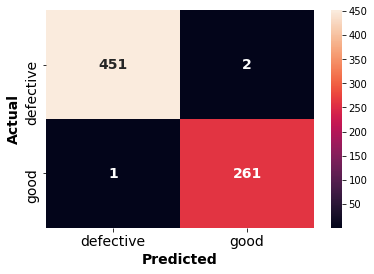

In [37]:
# Visualize the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(  confusion_matrix(test_dataset.classes,y_pred_class),
              annot=True,
              annot_kws={'size':14, 'weight':'bold'},
              fmt='d',
              xticklabels=['defective', 'good'],
              yticklabels=['defective', 'good'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()